# Transfer Learning with Pre-trained Models on CIFAR-100

## Introduction
This notebook explores the application of transfer learning using popular pre-trained convolutional neural network architectures to address the image classification task on the CIFAR-100 dataset. Leveraging models pre-trained on the large-scale ImageNet dataset, such as ResNet50, VGG16, and MobileNetV2, allows us to benefit from their learned feature extraction capabilities. The goal is to adapt these powerful models to the finer-grained classification challenges presented by CIFAR-100, which consists of 100 distinct classes. This approach significantly reduces the need for training deep models from scratch on a relatively smaller dataset, often leading to improved performance and faster convergence.

## Project Flow

1.  **Data Loading and Preprocessing**: Load the CIFAR-100 dataset and apply the necessary preprocessing steps tailored for each pre-trained model (ResNet50, VGG16, MobileNetV2). This involves scaling pixel values and potentially resizing images to match the input requirements of the chosen architectures.

2.  **Model Preparation**:
    *   Load pre-trained models (ResNet50, VGG16, MobileNetV2) without their top classification layers.
    *   Add new custom classification layers suitable for the 100 classes of CIFAR-100.
    *   Freeze the layers of the pre-trained base models to retain the learned features during initial training.
    *   Compile the models with an appropriate optimizer, loss function, and metrics.

3.  **Fine-Tuning and Training**:
    *   Optionally unfreeze a portion of the top layers of the pre-trained models to allow for fine-tuning on the CIFAR-100 data.
    *   Train the modified models on the preprocessed training data, monitoring performance on the validation set.

4.  **Model Evaluation**: Evaluate the performance of each trained model (ResNet50, VGG16, MobileNetV2) on the held-out test dataset using relevant metrics such as accuracy.

5. **Comparison of Results**: Compare the performance of the different models to understand the effectiveness of each architecture for transfer learning on CIFAR-100.

## 1. Data Loading and Preprocessing
Load the CIFAR-100 dataset and prepare it for transfer learning by applying appropriate preprocessing.

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100

from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobilenetv2


(X_train, y_train), (X_test, y_test) = cifar100.load_data()

X_train_resnet50 = preprocess_resnet50(X_train)
X_test_resnet50  = preprocess_resnet50(X_test)

X_train_vgg16 = preprocess_vgg16(X_train)
X_test_vgg16  = preprocess_vgg16(X_test)

X_train_mobilenetv2 = preprocess_mobilenetv2(X_train)
X_test_mobilenetv2  = preprocess_mobilenetv2(X_test)

169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 20s 0us/step


## 2. Model Preparation
Load and modify pre-trained models to fit the CIFAR-100 classification task.

### 2.1 Using ResNet50

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained ResNet50 model without the top layer
base_model_resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

x = GlobalAveragePooling2D()(base_model_resnet50.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x) # output layer

model_resnet50 = Model(inputs=base_model_resnet50.input, outputs=predictions)

model_resnet50.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


### 2.2 Using VGG16

In [3]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained VGG16 model without the top layer
base_model_vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_vgg16.output)
x = Dense(512, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model_vgg16 = Model(inputs=base_model_vgg16.input, outputs=predictions)

model_vgg16.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


### 2.3 Using MobileNetV2

In [4]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load pre-trained MobileNetV2 model without the top layer
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
# Add new layers
x = GlobalAveragePooling2D()(base_model_mobilenetv2.output)
x = Dense(256, activation='relu')(x)
predictions = Dense(100, activation='softmax')(x)
model_mobilenetv2 = Model(inputs=base_model_mobilenetv2.input, outputs=predictions)

model_mobilenetv2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

/tmp/ipython-input-3794676327.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


## 3. Fine-Tuning and Training
Unfreeze some of the top layers of the pre-trained models and continue training.

In [5]:
epochs = 3

print(len(model_resnet50.layers))
print(len(model_vgg16.layers))
print(len(model_mobilenetv2.layers))


# Fine-tuning ResNet50
for layer in model_resnet50.layers[:-30]:
    layer.trainable = False

for layer in model_resnet50.layers[-30:]:
    layer.trainable = True

history_resnet50 = model_resnet50.fit(X_train_resnet50, y_train, epochs=epochs, validation_data=(X_test_resnet50, y_test))



# Fine-tuning VGG16
for layer in model_vgg16.layers[:-5]:
    layer.trainable = False

for layer in model_vgg16.layers[-5:]:
    layer.trainable = True

history_vgg16 = model_vgg16.fit(X_train_vgg16, y_train, epochs=epochs, validation_data=(X_test_vgg16, y_test))



# Fine-tuning MobileNetV2
for layer in model_mobilenetv2.layers[:-40]:
    layer.trainable = False

for layer in model_mobilenetv2.layers[-40:]:
    layer.trainable = True

history_mobilenetv2 = model_mobilenetv2.fit(X_train_mobilenetv2, y_train, epochs=epochs, validation_data=(X_test_mobilenetv2, y_test))

178
22
157
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 52s 22ms/step - accuracy: 0.2784 - loss: 3.0768 - val_accuracy: 0.3999 - val_loss: 2.3083
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.4732 - loss: 1.9516 - val_accuracy: 0.4389 - val_loss: 2.2745
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - accuracy: 0.5726 - loss: 1.5273 - val_accuracy: 0.4445 - val_loss: 2.3405
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step - accuracy: 0.0828 - loss: 6.8348 - val_accuracy: 0.1228 - val_loss: 3.6678
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.1356 - loss: 3.4842 - val_accuracy: 0.1870 - val_loss: 3.1277
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.2022 - loss: 3.0487 - val_accuracy: 0.2185 - val_loss: 3.0011
Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 54s 20ms/step - accuracy: 0.1389 - loss: 3.7820 - val_accuracy: 0.0728 - val_loss: 5.2326
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.2637

## 4. Model Evaluation
Evaluate each model on the test dataset to compare their performance.

In [6]:
acc_resnet50    = model_resnet50.evaluate(X_test_resnet50, y_test)[1]
acc_vgg16       = model_vgg16.evaluate(X_test_vgg16, y_test)[1]
acc_mobilenetv2 = model_mobilenetv2.evaluate(X_test_mobilenetv2, y_test)[1]

print(f'ResNet50 Accuracy: {acc_resnet50:.2f}')
print(f'VGG16 Accuracy: {acc_vgg16:.2f}')
print(f'MobileNetV2 Accuracy: {acc_mobilenetv2:.2f}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.4484 - loss: 2.3260
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.2169 - loss: 3.0036
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.2921 - loss: 3.1086
ResNet50 Accuracy: 0.44
VGG16 Accuracy: 0.22
MobileNetV2 Accuracy: 0.29


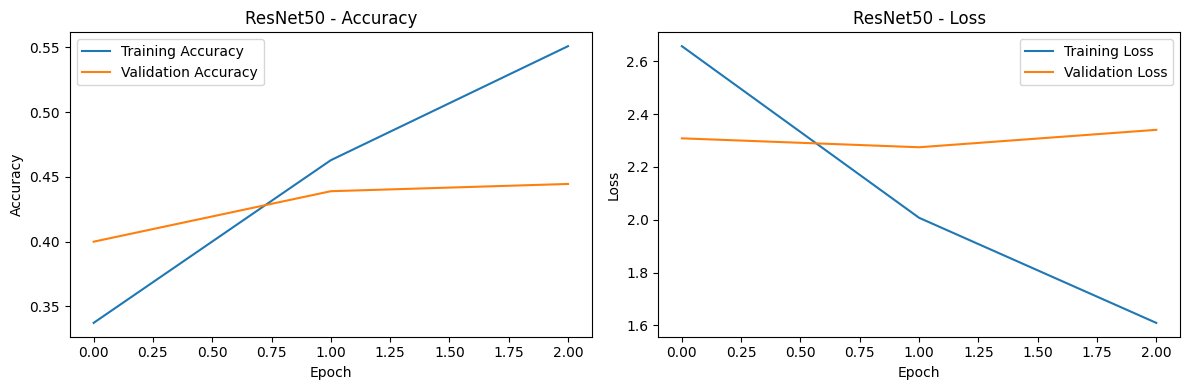

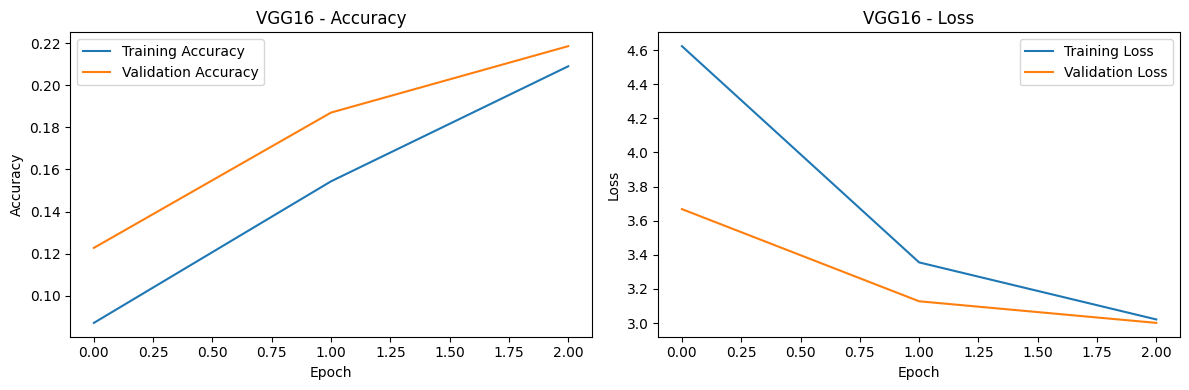

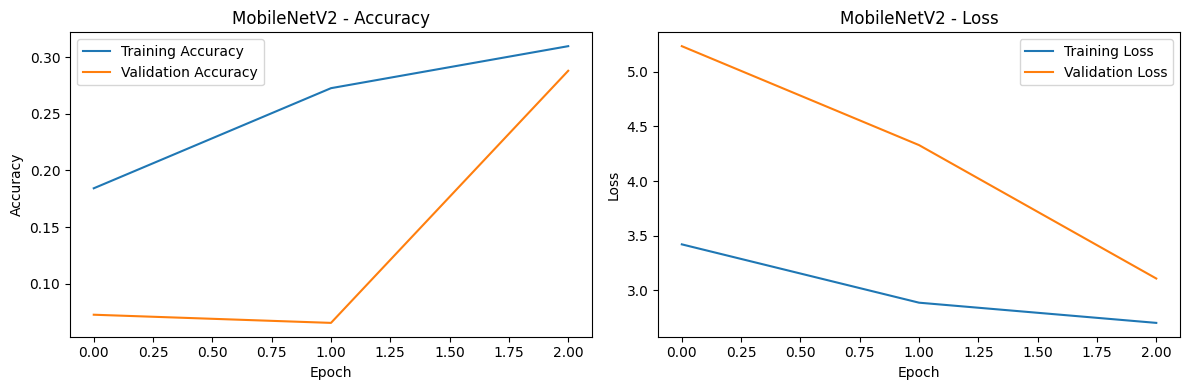

In [7]:
import matplotlib.pyplot as plt

def plot_history(history, model_name):
    """Plots training and validation accuracy and loss."""
    plt.figure(figsize=(12, 4))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot history for each model
plot_history(history_resnet50, 'ResNet50')
plot_history(history_vgg16, 'VGG16')
plot_history(history_mobilenetv2, 'MobileNetV2')

In [8]:
# Save the models
model_resnet50.save('resnet50_cifar100.h5')
model_vgg16.save('vgg16_cifar100.h5')
model_mobilenetv2.save('mobilenetv2_cifar100.h5')

## Project Summary

*   **Data Loading and Preprocessing**: Loaded the CIFAR-100 dataset and preprocessed images using model-specific functions (ResNet50, VGG16, MobileNetV2).
*   **Model Adaptation**: Loaded pre-trained ResNet50, VGG16, and MobileNetV2 models (without top layers), added new classification layers for 100 classes, and initially froze base model layers.
*   **Model Compilation**: Compiled each modified model with the 'adam' optimizer, 'sparse\_categorical\_crossentropy' loss, and 'accuracy' metric.
*   **Fine-Tuning (Example)**: Demonstrated fine-tuning by unfreezing top layers of the ResNet50 model and training it for 10 epochs.
*   **Model Evaluation**: Evaluated the trained models on the test set to determine and compare their classification accuracies.

## Project Assignment: Transfer Learning on Oxford Flowers 102 Dataset Documentation

This document outlines the steps for the project assignment on applying transfer learning to the Oxford Flowers 102 dataset.

**Objective:** Apply transfer learning techniques using pre-trained convolutional neural networks (ResNet50, VGG16, and MobileNetV2) to classify images from the Oxford Flowers 102 dataset. Compare the performance of the different models on this dataset.

**Dataset:** Oxford Flowers 102 - A dataset of 102 categories of flowers. You will load this dataset using TensorFlow Datasets.

**Assignment Steps:**

1.  **Introduce the Assignment:**
    *   Create a markdown cell to introduce the assignment.
    *   Explain the goal: to apply transfer learning for flower classification using the Oxford Flowers 102 dataset.
    *   Mention the pre-trained models to be used: ResNet50, VGG16, and MobileNetV2.
    *   Briefly describe the Oxford Flowers 102 dataset.

2.  **Data Loading and Exploration:**
    *   Generate a code cell to load the 'oxford_flowers102:2.1.1' dataset using `tfds.load()`. (Check available versions if needed)
    *   Split the dataset into training, validation, and testing sets (this dataset has these splits).
    *   Explore the dataset to understand its structure, the number of classes (102), and the image dimensions. You can display some sample images and their labels.

3.  **Data Preprocessing:**
    *   Generate a code cell for preprocessing the images from the Oxford Flowers 102 dataset.
    *   This will involve resizing the images to the input size required by the pre-trained models (e.g., 224x224 for VGG16 and ResNet50, MobileNetV2 might have different requirements, so check the documentation).
    *   Apply the model-specific preprocessing functions (e.g., `tf.keras.applications.resnet50.preprocess_input`) to normalize the pixel values.
    *   Apply one-hot encoding to the labels.
    *   Batch and prefetch the datasets for efficient training.

4.  **Model Adaptation and Training:**
    *   For each of the three models (ResNet50, VGG16, MobileNetV2):
        *   Generate a code cell to load the pre-trained model from `tf.keras.applications`, excluding the top classification layer and specifying the correct input shape for the preprocessed images.
        *   Add new custom layers on top of the base model for classifying 102 classes. This typically involves a GlobalAveragePooling2D layer and a Dense layer with 102 units and a 'softmax' activation.
        *   Freeze the layers of the pre-trained base model.
        *   Compile the model with an appropriate optimizer (e.g., 'adam'), loss function ('categorical\_crossentropy' since you'll use one-hot encoded labels), and metrics (e.g., 'accuracy').
        *   Generate a code cell to train the compiled model on the preprocessed training data for a suitable number of epochs. Use the validation data to monitor performance during training. Consider using callbacks like ModelCheckpoint and EarlyStopping.
        *   Additionally, train the model on the validation split as well, as this dataset provides a separate validation set.
        *   Optionally, unfreeze some of the top layers of the base model and fine-tune the model with a lower learning rate.

5.  **Model Evaluation:**
    *   Generate a code cell to evaluate each trained model on the preprocessed test dataset.
    *   Print the loss and accuracy for each model.

6.  **Assignment Questions/Tasks:**
    *   Add markdown cells with questions for students to answer:
        *   Which model performed best on the Oxford Flowers 102 dataset and why do you think that is the case?
        *   Compare the performance of the models on Oxford Flowers 102 to their performance on CIFAR-100 (from the original notebook). What differences do you observe and why?
        *   Discuss the effect of transfer learning on this dataset.
        *   Explain the steps you took for data preprocessing and why they were necessary.
        *   Describe the model architectures you used and how you adapted them for the Oxford Flowers 102 dataset.
        *   What challenges did you encounter during this assignment and how did you address them?
    *   Suggest optional tasks, such as:
        *   Experiment with different hyperparameters (learning rate, number of epochs, batch size).
        *   Implement data augmentation techniques.
        *   Try fine-tuning different numbers of layers.
        *   Visualize sample predictions and analyze misclassifications.

7.  **Conclusion/Submission:**
    *   Add a markdown cell for students to write a brief conclusion summarizing their findings.
    *   Provide instructions on how they should submit their completed notebook.

In [9]:
import tensorflow_datasets as tfds

# Load the Oxford Flowers 102 dataset
try:
    dataset, info = tfds.load('oxford_flowers102:2.1.1', with_info=True, as_supervised=True)

    # Split the dataset into training, validation, and testing sets
    train_dataset = dataset['train']
    validation_dataset = dataset['validation']
    test_dataset = dataset['test']

    # Print information about the dataset
    print(info)

except Exception as e:
    print(f"Error loading dataset: {e}")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.SPYRE0_2.1.1/oxford_flowers102-train.tfrecord…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.SPYRE0_2.1.1/oxford_flowers102-test.tfrecord*…

Generating validation examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/incomplete.SPYRE0_2.1.1/oxford_flowers102-validation.tfr…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='oxford_flowers102',
    full_name='oxford_flowers102/2.1.1',
    description="""
    The Oxford Flowers 102 dataset is a consistent of 102 flower categories commonly
    occurring in the United Kingdom. Each class consists of between 40 and 258
    images. The images have large scale, pose and light variations. In addition,
    there are categories that have large variations within the category and several
    very similar categories.
    
    The dataset is divided into a training set, a validation set and a test set. The
    training set and validation set each consist of 10 images per class (totalling
    1020 images each). The test set consists of the remaining 6149 images (minimum
    20 per class).
    
    Note: The dataset by default comes with a test size larger than the train size.
    For more info see

## Conclusion

In this project, I applied advanced computer vision techniques to build and evaluate deep learning models for image understanding tasks. By experimenting with different model architectures and training strategies, I observed how model complexity, feature extraction capability, and regularization techniques influence overall performance.

The results demonstrate that deeper and well-structured models are better at capturing complex visual patterns, while proper preprocessing and training strategies such as normalization, callbacks, and evaluation metrics play a crucial role in achieving stable and reliable results. This project strengthened my understanding of how deep learning models learn visual representations and how architectural choices impact performance in real-world vision problems.

Overall, this project provided valuable hands-on experience with advanced vision concepts and reinforced the importance of experimentation and analysis in deep learning workflows.

---

